In [97]:
import numpy as np
import pandas as pd
from pathlib import Path
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
import os
import glob
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from sklearn import datasets, linear_model, metrics

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', None)

np.random.seed(0)

In [98]:
data_dir = Path('./Aug12')
data_dir6 = Path("./new_files_july23/") 

In [99]:
# Params
params = {'n_estimators': 500,
          'max_depth': 5,
          'min_samples_split': 5,
          'learning_rate': 0.1,
          'loss': 'ls'}

In [100]:
def convert(df: pd.DataFrame, frame_size=10):
    x = np.asarray(df.iloc[:, 1]).reshape(-1, frame_size)
#     x = x[x.shape[0]//10:-x.shape[0]//10]
    return x

def convert_prev(df: pd.DataFrame, frame_size=129):
    x = np.asarray(df.iloc[:, 1]).reshape(-1, frame_size)
#     x = x[x.shape[0]//10:-x.shape[0]//10]
    return x

In [101]:
df5 = pd.read_csv(data_dir / "fan_mix.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df5 = df5[df5['frequency'] != "clocktime"]
df5 = df5.dropna()
df5[:10*11]

,frequency,amplitude
0,0.00,56372.4402
1,62.50,24672.1224
2,125.00,445.8191
3,187.50,278.4682
4,250.00,231.9342
...,...,...
115,312.50,200.0926
116,375.00,501.7897
117,437.50,419.5434
118,500.00,162.6519


In [102]:
df1 = pd.read_csv(data_dir / "fan_high.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df1 = df1[df1['frequency'] != "clocktime"]
df1 = df1.dropna()
df1 = convert(df1)

df2 = pd.read_csv(data_dir / "fan_low1.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df2 = df2[df2['frequency'] != "clocktime"]
df2 = df2.dropna()
df2 = convert(df2)

df3 = pd.read_csv(data_dir / "fan_med1.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df3 = df3[df3['frequency'] != "clocktime"]
df3 = convert(df3)

# df4 = pd.read_csv(data_dir6 / "no_air.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
# df4 = df4[df4['frequency'] != "clocktime"]
# df4 = df4.dropna()
# df4 = convert_prev(df4)
# df4 = df4[:, :10]


df5 = pd.read_csv(data_dir / "fan_mix.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df5 = df5[df5['frequency'] != "clocktime"]
df5 = df5.dropna()
# print(df[:10*739])
df5 = convert(df5)
# df4 = pd.read_csv(data_dir / "180.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
# df5 = pd.read_csv(data_dir / "32cm_away.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)


In [103]:
df5.shape

(7392, 10)

In [104]:

df = np.concatenate([df1, df2,df3, df5])


In [105]:
# df = df[df.columns[1:2]]


In [106]:
# data = convert(df)
data = df


In [107]:
X = data[:,:-1]

X = X[:, :7]
X.shape

(10046, 7)

In [108]:
y = data[:, -1]
y.shape


(10046,)

In [109]:
print (X.shape, y.shape)

(10046, 7) (10046,)


In [110]:
print(max(y), min(y))
for i in range(len(y)):
    if i >= len(y):
        break
    if y[i]>35 or y[i]<1:
        print (i, y[i])
        X = np.delete(X, i, axis = 0)
        y = np.delete(y, i)
        

28.44 2.57


In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [112]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)


GradientBoostingRegressor(max_depth=5, min_samples_split=5, n_estimators=500)

In [113]:
from joblib import dump, load
dump(reg, "flowSense.joblib")

['flowSense.joblib']

In [114]:
y_pred = reg.predict(X_test)
y_train_pred = reg.predict(X_train)

In [115]:
print(y_pred[:5])
print(y_test[:5])

[16.43005545 11.79454976 14.15081519 16.1687745   8.32667058]
[14.35 22.15  7.77  8.58 11.21]


In [116]:
print(y_train_pred[:5])
print(y_train[:5])

[15.9499942  13.57669696 12.15703458 16.08034813 17.86119386]
[16.25 12.44  9.6  23.27 18.55]


In [117]:
print("MSE of test: ", mean_squared_error(y_test, y_pred))
print(y_pred.shape)

print("Test Reg score: ", reg.score(X_test, y_test))
    

MSE of test:  34.149821087099916
(2010,)
Test Reg score:  0.10607035533675502


In [118]:
print("MSE of training: ",  mean_squared_error(y_train, y_train_pred))

print("Train Reg score: ", reg.score(X_train, y_train))

MSE of training:  13.151644060859747
Train Reg score:  0.6623463613036362


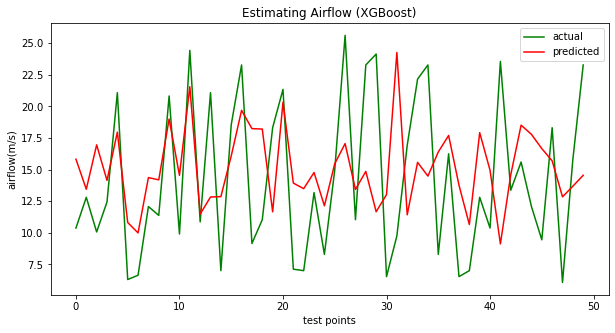

In [119]:
plt.figure(figsize=(10,5))
plt.plot(y_test[50:100], 'g', label="actual")
plt.plot(y_pred[50:100], 'r', label="predicted")
plt.legend()
plt.xlabel("test points")
plt.ylabel("airflow(m/s)")
plt.title("Estimating Airflow (XGBoost)")
plt.savefig("final.png")

Text(0.5, 1.0, 'Estimating Airflow (XGBoost)')

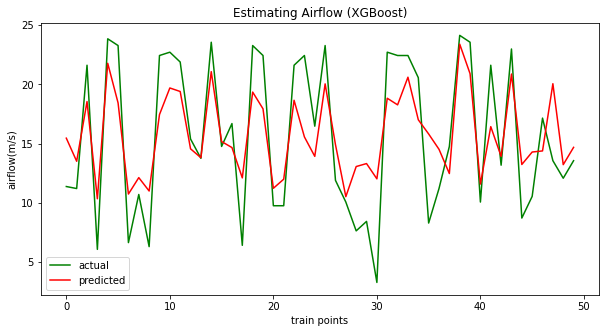

In [120]:
plt.figure(figsize=(10,5))
plt.plot(y_train[50:100], 'g', label="actual")
plt.plot(y_train_pred[50:100], 'r', label="predicted")
plt.legend()
plt.xlabel("train points")
plt.ylabel("airflow(m/s)")
plt.title("Estimating Airflow (XGBoost)")
# plt.savefig("1m_v1.jpg")

